# Lab 9: Twitter data analysis  

In this lab, we will learn how to read JSON files and how to perform exploratory analysis of twitter data. As an extra credit, you will learn how to use API to download tweets on the topic of your choice.

Let us start by importing the needed packages.

In [1]:
import json
import random
import time
import calendar
import codecs
import datetime
import sys
import gzip
import string
import glob
import os
import numpy as np
import dateutil.parser

## Module 0: Reading Tweets

Tweets are saved in the form of a JSON file. Open `onetweet` file in a text editor and study how it looks. This file contains information from a single tweet. The file is written in the JSON format, which is easy for a computer to read and parse. 

**Question 1**. Google `JSON` and try to learn about this particular data format. Explain in one or two paragraphs what you learned.

**ANSWER 1**
JSON is short for JavaScrip Object Notation. JSON is used typically to transmit data over web from servers to clients. It is a way to format a file so that it can be easily send as it is lightweight and easy to read/write. It is also easier to parse and generate the data thus used by many websites like Twitter. The way JSON is formated it is basically a huge dictionary in which their is a key paired with a value or values with keys seprated by commas and entire thing enclosed in curly braces to indicate it is an object.


Let us read `onetweet` JSON file. We will create an object and print it.

In [2]:
from pprint import pprint
tweet = json.load(open('onetweet', 'rb'))
pprint (tweet)

{'_id': '264230205529411585',
 'contributors': None,
 'coordinates': {'coordinates': [-73.95639896, 40.71411847], 'type': 'Point'},
 'created_at': '2012-11-02T04:59:24',
 'disaster': '2012_sandy_hurricane_en',
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [{'display_url': 'instagr.am/p/Rg70o6xlkY/',
                        'expanded_url': 'http://instagr.am/p/Rg70o6xlkY/',
                        'indices': [33, 53],
                        'url': 'http://t.co/G0LdsQAz'}],
              'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'geo': {'coordinates': [40.71411847, -73.95639896], 'type': 'Point'},
 'id': '264230205529411585',
 'id_str': '264230205529411585',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': {'attributes': {},
           'bounding_box': {'coordinat

As we can see, each tweet is stored in a dictionary. Although there are more than 20 different keys in the dictionary, we introduce the most important fields which will be used in the rest of this lab.
<ul>
<li>'_id': shows the unique id of this tweet.</li>

<li>'coordinates': shows the location from which the tweet was posted. The field might be null if the tweet contains no location data, or it could contain bounding box information, place information, or GPS coordinates in the form of (longitude, latitude). </li>

<li>'created_at': shows the time the tweet has been created.</li>

<li>'text': shows the text of the tweet.</li>

<li>'user': contains multiple dictionaries describing the user, including the name of this user, the number of followers, the number of friends...</li>
</ul>

**Question 2**. Explain 3 more keys that you find interesting

**ANSWER 2**
- A key I found intersting was in the entites key there are more keys specifically hastags. Hashtags are a key part of the way people use Twitter as typically people will add multiple hastags which are suppose to categorize a tweet based on intention or realtness.
- The "disaster" key is also interesting as it can also be used to categorize tweets based upon a specific disaster like in this case this tweet is supposed to be realted to 2012 Huricane Sandy.
- the "urls" key in entites key is also intriguing as we can learn if this tweet orignated on twitter or from other application, which in this case it is actually an instagram post used to make a tweet http://instagr.am/p/Rg70o6xlkY/.

In the following code we will load around 4,000 tweets sent from New York City region during Sandy Hurricane from a JSON file `myNYC.json`. As part of this process, we will extract each tweet's post time and create a time series of the number of tweets in each hour during the event.

In [3]:
filePath='smallNYC.json'
localTweetList = []
globalTweetCounter = 0
frequencyMap = {}
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    
    # Try to extract the time of the tweet
    currentTime=dateutil.parser.parse(tweetObj['created_at'])
    currentTime = currentTime.replace(second=0)
    currentTime = currentTime.replace(minute=0)

    #print currentTime
    # Increment tweet count
    globalTweetCounter += 1
    
    # If our frequency map already has this time, use it, otherwise add
    if ( currentTime in frequencyMap.keys() ):
        timeMap = frequencyMap[currentTime]
        timeMap["count"] += 1
        timeMap["list"].append(tweetObj)
    else:
        frequencyMap[currentTime] = {"count":1, "list":[tweetObj]}

# Fill in any gaps
times = sorted(frequencyMap.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

#timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
timeIntervalStep = datetime.timedelta(hours=1)
while ( thisTime <= lastTime ):
    if ( thisTime not in frequencyMap.keys() ):
        frequencyMap[thisTime] = {"count":0, "list":[]}
        
    thisTime = thisTime + timeIntervalStep

print ("Processed Tweet Count:", globalTweetCounter)

Processed Tweet Count: 4295


## Module 1: Simple Frequency Analysis

In this section, we will cover a few simple analysis techniques for EDA of the available twitter datay.

- Twitter Timeline
- Top Twitter Users
- Twitter API
- Posting Frequency Distribution
- Popular Hashtags
- Simple Event Detection
- Language Distributions

### Twitter Timeline 

To build a timeline of Twitter usage, we can simply plot the number of tweets posted per hour.

Time Frame: 2012-10-22 05:00:00 2012-11-02 04:00:00


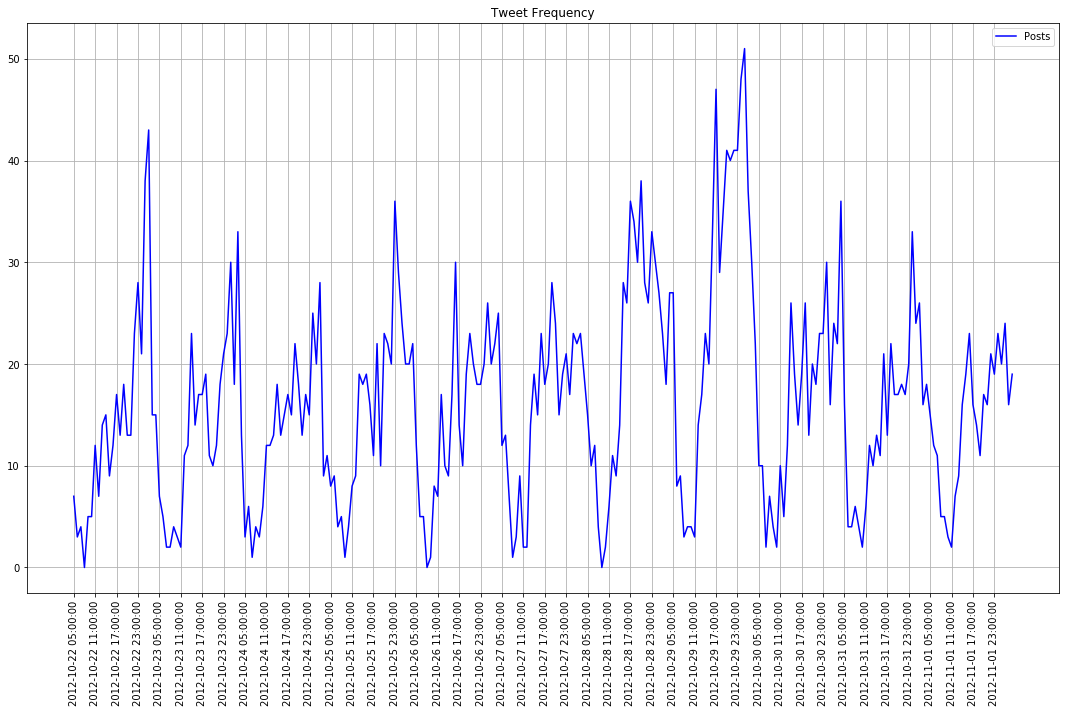

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")

# Sort the times into an array for future use
sortedTimes = sorted(frequencyMap.keys())

# What time span do these tweets cover?
print ("Time Frame:", sortedTimes[0], sortedTimes[-1])

# Get a count of tweets per minute
postFreqList = [frequencyMap[x]["count"] for x in sortedTimes]

# We'll have ticks every thirty minutes (much more clutters the graph)
smallerXTicks = range(0, len(sortedTimes), 6)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
ax.plot(range(len(frequencyMap)), [x if x > 0 else 0 for x in postFreqList], color="blue", label="Posts")
ax.grid(b=True, which=u'major')
ax.legend()

plt.show()

**Question 3**. When is the tweeting activity the largest? Find a wikipedia article about the Sandy Hurricane to understand the timeline of events surrounding it. Discuss if you see a correlation with the tweet frequencies. Select some tweets from different time points and see if the messages are correlated with the events on the ground.

In [7]:
#Answer 3
maxValue = max(postFreqList)
maxIndex = postFreqList.index(maxValue)
maxTweetTime = sortedTimes[maxIndex]
print ('The max amount of tweets was %s at %s\n' %( str(maxValue) ,str(maxTweetTime)))

#Sort list by frequency of values in reverse order
sortedFreqList = sorted(postFreqList, reverse=True)
#records of the last 
for y in sortedFreqList[:5]:
    index = postFreqList.index(y)
    tweetTime = sortedTimes[index]
    for x in range(0,2):
        print("A tweet at time %s was: %s" %(str(tweetTime), str((frequencyMap[tweetTime]["list"][x]["text"]))))
    print ()

The max amount of tweets was 51 at 2012-10-30 01:00:00

A tweet at time 2012-10-30 01:00:00 was: @bpacris power and Internet. Text if you need to come this way.
A tweet at time 2012-10-30 01:00:00 was: @aviggz so does mine she keeps saying its the end of the world

A tweet at time 2012-10-30 00:00:00 was: @MintoInc fire nearby from sandy  http://t.co/VFMb2QzJ
A tweet at time 2012-10-30 00:00:00 was: Made another video #crazzy

A tweet at time 2012-10-29 17:00:00 was: Battery Park zojuist afgesloten. Op naar Wall Street. #SVJgoesUSA #Sandy
A tweet at time 2012-10-29 17:00:00 was: @rayraydel @meredi Not to minimize it but at the end of 2nd St the canal is usually only about 1/2 foot below the edge

A tweet at time 2012-10-23 02:00:00 was: Swappi - Party Vibes. That song is BANANAS!
A tweet at time 2012-10-23 02:00:00 was: Ahhhhh #BGC9 reunion time!!!!!!!

A tweet at time 2012-10-29 20:00:00 was: Scratch bout to take this nap
A tweet at time 2012-10-29 20:00:00 was: No power.



## **ANSWER 3**
### The Top 5 times with the most tweets were:
- October 30, 2012 1 AM
- October 30, 2012 12 AM
- October 29, 2012 5 PM
- October 23, 2012 2 AM
- October 29, 2012 8 PM

From this we can see that most of the tweets came around October 29-30 which is exactly when hurricane Sandy hit Northeastern states in this case New York. We can see that there is a definite postive correlation with the most tweets related to when Hurricane Sandy first made landfall, when it was at its worst, and to when it died down seen from the tweets like "No Power", "Not to minimize it but at the end of 2nd St the canal is usually only about 1/2 foot below the edge", "@MintoInc fire nearby from sandy"," @bpacris power and Internet. Text if you need to come this way".  

### Top Twitter Users

The following piece of code reveals the users that produced the most tweets. 

In [7]:
# Create maps for holding counts and tweets for each user
globalUserCounter = {}
globalUserMap = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        
        if ( user not in globalUserCounter ):
            globalUserCounter[user] = 1
            globalUserMap[user] = [tweet]
        else:
            globalUserCounter[user] += 1
            globalUserMap[user].append(tweet)

print ("Unique Users:", len(globalUserCounter.keys()))

Unique Users: 3042


In [8]:
sortedUsers = sorted(globalUserCounter, key=globalUserCounter.get, reverse=True)
print ("Top Ten Most Prolific Users:")
for u in sortedUsers[:10]:
    print (u, globalUserCounter[u], "\n\t", "Random Tweet:", globalUserMap[u][0]["text"], "\n----------")

Top Ten Most Prolific Users:
Young_Boss718 37 
	 Random Tweet: That random text  I had got be for LMFAO shit was funny 
----------
frankieciv608 15 
	 Random Tweet: “@JohnKincade Dear Donald Trump,
Americans &amp; Republicans chose to not involve you in this election between Prez &amp; Romney.
Please go away.” 
----------
Cocky_Johnny 15 
	 Random Tweet: @_tinaDeex3 LMAO #Dead 
----------
labroides 14 
	 Random Tweet: @SharkDevocean best of luck. That's awesome 
----------
ReelTalker 12 
	 Random Tweet: @FilmFatale_NYC also, in other news, i totally thought it was idris who tweeted me. Saw the pic and got  excited :-) 
----------
Amooniac 11 
	 Random Tweet: Je Hyper nul en Francais mais je sais qu'on ne dit pas le PLUS piire ! SEIGNEUR aidez moi a comprendre ce qui n'a pas marché ak @mhathe911 
----------
kcastrox3 11 
	 Random Tweet: Cuz this love is a sure thing. 
----------
carolsommers727 11 
	 Random Tweet: @coreymach lookin spiffy 👌 
----------
_LizmaryA 11 
	 Random Tweet: Hey 

**Question 4**. Find and print the top 10 users with the most friends. Find and print the top 10 users with the most followers. 

In [9]:
###ANSWER 4
# Create maps for holding friend count for each user
FriendCounter = {}
FollowerCounter ={}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        friendCount= tweet["user"]["friends_count"]
        followerCount= tweet["user"]["followers_count"]
        if ( user not in FriendCounter):
            FriendCounter[user] = friendCount
        if( user not in FollowerCounter):
            FollowerCounter[user]=followerCount
sortedUsersFriend = sorted(FriendCounter, key=FriendCounter.get, reverse=True)
sortedUsersFollow = sorted(FollowerCounter, key=FollowerCounter.get, reverse=True)
print ("Top Ten Users With Most Friends:")
for u in sortedUsersFriend[:10]:
    print (u,"-", FriendCounter[u], )
print ("\n\nTop Ten Users With Most Followers:")
for u in sortedUsersFollow[:10]:
    print (u,"-", FollowerCounter[u])    

Top Ten Users With Most Friends:
mstupenengo - 49501
GinsburgJobs - 49441
WeAreJocelyn - 37969
MrThugZilla2K15 - 33902
davesurber - 29221
55_althani - 26414
EddieJMontanez - 21662
andrewcotto - 17312
MargaretMolloy - 16958
tupaclivesss - 11334


Top Ten Users With Most Followers:
mstupenengo - 1162644
iJokes_ - 185923
felixsalmon - 164709
EmersonOverton - 155045
umakhouny - 126453
AgramyQ8 - 112323
55_althani - 94191
QueensMuseum - 80871
JosephWakile - 73103
Majovargas_ - 67256


### Distribution of Postings

It appears a few users were posting to Twitter a lot. But how often did most Twitter users tweet during this time? We can build a histogram to see this distribution.


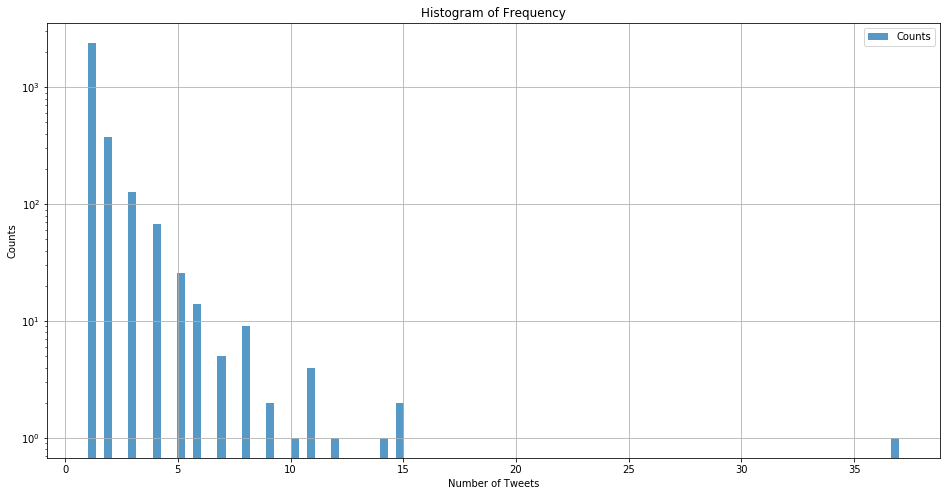

In [10]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.hist(
    [globalUserCounter[x] for x in globalUserCounter], 
    bins=100, 
    normed=0, 
    alpha=0.75,
    label="Counts",
    log=True)

plt.xlabel('Number of Tweets')
plt.ylabel('Counts')
plt.title("Histogram of Frequency")
plt.grid(True)
plt.legend()

plt.show()

**Question 5**. Study 3 users with the most posts. What were they tweeting about?

In [11]:
for x in sortedUsers[:3]:
    print (x," tweets are:")
    print ("-"*40)
    for tweet in range(0,len(globalUserMap[x])):
        print (globalUserMap[x][tweet]["text"])
    print ("\n\n")

Young_Boss718  tweets are:
----------------------------------------
That random text  I had got be for LMFAO shit was funny
@MeerGotGame don't try and find shit lol
U inbox her on fb or text her
That wax museum is a fool in New York shit be real af
I kinda just felt when she just said idgaf lol
We be on the loud shit
Y'all be smoking that low volume
@BossBitchShxt chill out Monae you know I fucks with fab lol
I got my list tho 🙈🙉🙊
@The_Good_Fella9 it's ok
@NOFcks_Givn gave that head to ?
PART2
@The_Good_Fella9 word she's cool af
i wonder who had crush on me on twitter 😜😝😛😵
White girls don't have butts LMFAO
@BricksFromPluto lol
@SugarCocaine_ well I heard mad down south ppl say it that's why I ask
Getting alil sleepy
Moms gone for the whole night shit just about to smoke &amp; kick it with da homies
@LiyahhDoeee I know that's not you in them heels and skirt
@MikeyGotBudd I fucks with the mishka shirt fam
@Loud_Everyday 💯 already know
@She_Suckedd nigga shut up 😒
The pic jaida just post

### Answer 5
From looking at the top three users we can see that Young_Boss718 basically talks about many random/profane things as well as tagging others/ making a comment towards them, frankieciv608 talks about poltics and major events in the news, and lastly Cocky_Johnny talks about his desire for a woman as well as opinions.

### Average Number of Posts

In [12]:
avgPostCount = np.mean([globalUserCounter[x] for x in globalUserCounter])
print("Average Number of Posts:", avgPostCount)

Average Number of Posts: 1.4119000657462195


### Popular Hashtags

Hashtags give us a quick way to view the conversation and see what people are discussing. Getting the most popular hashtags is just as easy as getting the most prolific users.


In [13]:
# A map for hashtag counts
hashtagCounter = {}

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            
            if ( hashtagString not in hashtagCounter ):
                hashtagCounter[hashtagString] = 1
            else:
                hashtagCounter[hashtagString] += 1

print ("Unique Hashtags:", len(hashtagCounter.keys()))
sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
print ("Top Twenty Hashtags:")
for ht in sortedHashtags[:20]:
    print ("\t", "#" + ht, hashtagCounter[ht])

Unique Hashtags: 997
Top Twenty Hashtags:
	 #sandy 108
	 #nyc 47
	 #hurricanesandy 26
	 #newyork 12
	 #brooklyn 9
	 #halloween 8
	 #instagood 8
	 #photooftheday 8
	 #frankenstorm 8
	 #hurricane 8
	 #centralpark 7
	 #debates 6
	 #instamood 6
	 #satstudytime 6
	 #igers 5
	 #picoftheday 5
	 #instagramhub 5
	 #instadaily 5
	 #oomf 5
	 #newyorkcity 5


### Event Detection w/ Keyword Frequency

Twitter is good for breaking news. When an impactful event occurs, we often see a spike on Twitter of the usage of a related keyword. Some examples are below.


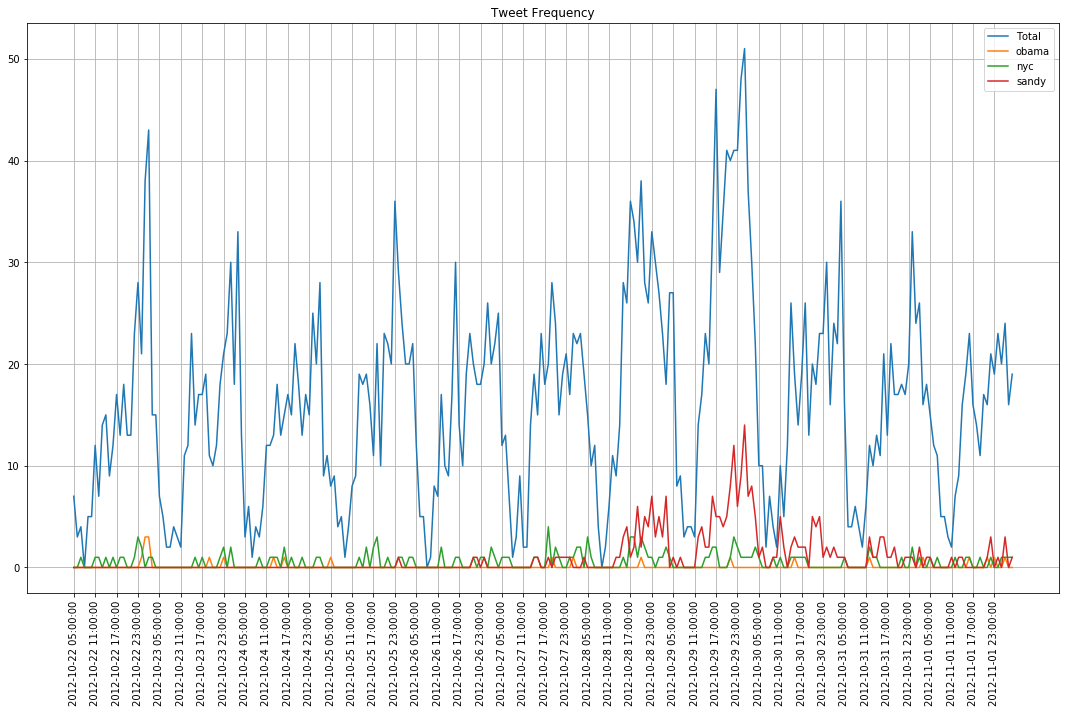

In [14]:
# What keywords are we interested in?
targetKeywords = ["obama", "nyc"]
# targetKeywords.append("lowery")
# targetKeywords.append("reilly")
targetKeywords.append("sandy")

# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if ( keyword in tweetString ):
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

ax.plot(range(len(frequencyMap)), totalCount, label="Total")


for keyword in targetKeywords:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

**Question 6**. Study some example codes with 2 different hashtags. Explain how are those messages different. 

In [15]:
# Question 6
hashtagCounter={}
hashtagMap = {}
# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            if ( hashtagString not in hashtagCounter ):
                hashtagCounter[hashtagString] = 1
                hashtagMap[hashtagString] = [tweet]
            else:
                hashtagCounter[hashtagString] += 1
                hashtagMap[hashtagString].append(tweet);

sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
for u in sortedHashtags[:2]:
    print ("#", u, ":")
    for tweet in range(0,20):
        print (tweet+1," ",hashtagMap[u][tweet]["text"])
    print ("\n")

# sandy :
1   #Sandy looks bad
2   Hurricane preparation in #NYC for the 2nd time in a year.  #dayaftertomorrow #sandy
3   Came to grab groceries like I do every Sunday. Currently involved in what I can only describe as the end of the world. Thanks #sandy.
4   Mandatory evacuation for #frankenstoem #sandy.
5   “@WalkingDead_AMC: #Sandy, please don't come for #TheWalkingDead tonight! ⚡☔🌀”
6   Escape from NYC Chris #sandy (@ Grand Central Terminal w/ 51 others) http://t.co/KU2mTKEe
7   #Sandy #nyc 뉴욕뉴저지지역 현재 허리케인 샌디 북상중으로 비상대비요망! 지하철 오늘 19시부터 안다니고 오늘밤부터 낼밤까진 꼼짝마라입니당~ 어제 간만에 할로윈파뤼가서 신나게놀다오길 잘했당ㅋ낼 회사도 휴무예정!이쪽에 계신분들 stay safe!
8   Todos los cruceros y ferries se suspenden hasta nuevo aviso #NYC #Sandy
9   No risk of scurvy up here! #Sandy #ZoneC  @ Upper East Side http://t.co/xiCg0OXD
10   The XX is off. Thanks #Sandy.
11   In case the sign didn't tip you off, high winds are coming. #sandy @ Frying Pan http://t.co/C42U9QqD
12   Giants are in serious trouble like #MittRomney. #Giants better 

### Answer 6
We can see that all the tweets with #sandy all relate and are more serious tweets while the tweets with #nyc are generally energtic and exicting yet all random. Some of the tweets with #nyc even talk about the hurricane.

**Question 7**. Which among the top 20 hashtags are related to Sandy. What are the most popular non-Sandy hashtags? 

**ANSWER 7**
<p>The related hastags to Sandy</p>
>* #sandy 
>* #hurricanesandy 
>* #frankenstorm 
>* #hurricane

<p>The unlrelated</p>
>*	 #halloween 
>*	 #instagood 
>*	 #centralpark 
>*	 #debates 
>*	 #instamood 
>*	 #satstudytime 
>*	 #igers 
>*	 #picoftheday 
>*	 #instagramhub 
>*	 #instadaily 
>*	 #oomf 

The other hastags like nyc depend on tweet

	 

**Question 8**.Among the top 20 hashtags, try to find which of them were particularly popular before Sandy, during Sandy, and those whose popularity did not change much. Try to apply k-means clustering on the time series of hashtags to try to find similar groups of hashtags. Discuss your findings.

Top Hastags before Sandy
# nyc
# newyork
# brooklyn
# halloween
# instagood
# photooftheday
# frankenstorm
# centralpark
# debates
# instamood
# satstudytime
# igers
# picoftheday
# instagramhub

Top Hashtags During Sandy:
# sandy
# nyc
# hurricanesandy
# newyork
# brooklyn
# frankenstorm
# hurricane
# centralpark
# newyorkcity

Unchanged Popularity:
# nyc
# newyork
# brooklyn
# frankenstorm
# centralpark


Text(0,0.5,'Count During Sandy')

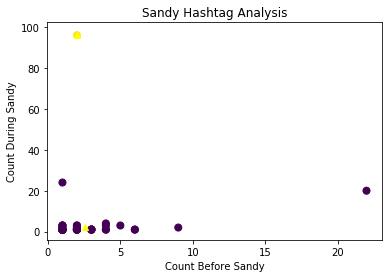

In [16]:
# Question 8 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from pandas import crosstab
from pandas.tools.plotting import scatter_matrix
import pandas as pd
%matplotlib inline

# A map for hashtag counts
beforeS = {}
duringS = {}

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    if(t <= datetime.datetime(2012, 10, 28, 11, 0)):##before SANDy
        for tweet in timeObj["list"]:
            hashtagList = tweet["entities"]["hashtags"]
            for hashtagObj in hashtagList:
                # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
                hashtagString = hashtagObj["text"].lower()
                if ( hashtagString not in beforeS ):
                    beforeS[hashtagString] = 1
                else:
                    beforeS[hashtagString] += 1
                    
    if((t > datetime.datetime(2012, 10, 28, 11, 0)) and (t < datetime.datetime(2012, 11, 1, 0, 0))): #during
        for tweet in timeObj["list"]:
            hashtagList = tweet["entities"]["hashtags"]
            for hashtagObj in hashtagList:
                # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
                hashtagString = hashtagObj["text"].lower()
                if ( hashtagString not in duringS ):
                    duringS[hashtagString] = 1
                else:
                    duringS[hashtagString] += 1

sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
sortedBefore = sorted(beforeS, key=beforeS.get, reverse=True)
sortedDuring = sorted(duringS, key=duringS.get, reverse=True)

print ("Top Hastags before Sandy")
for tag1 in sortedHashtags[:20]:
    for tag2 in sortedBefore[:20]:
        if(tag1 == tag2):
            print ("#", tag1)

print ("\nTop Hashtags During Sandy:")
for tag1 in sortedHashtags[:20]:
    for tag2 in sortedDuring[:20]:
        if(tag1 == tag2):
            print ("#", tag1)
            
print ("\nUnchanged Popularity:")
for tag1 in sortedHashtags[:20]:
    for tag2 in sortedBefore[:20]:
        for tag3 in sortedDuring[:20]:
            if(tag1 == tag2 == tag3):
                print ("#", tag1)
                
labels = []
X = []
y = []
for tag1 in sortedBefore[:]:
    for tag2 in sortedDuring[:]:
        if(tag1 == tag2):
            X.append(beforeS[tag1])
            y.append(duringS[tag2])
            labels.append(tag1)

dnew = np.column_stack((X, y))
kmeans = KMeans(n_clusters=2, random_state=0).fit(dnew)
cl=kmeans.labels_
cen=kmeans.cluster_centers_

# plot the results
plt.figure()
plt.scatter(dnew[:,0],dnew[:,1],c=cl, label=labels, s=50,facecolors='none')
plt.scatter(cen[:,0],cen[:,1], marker="^",color="yellow")
plt.title("Sandy Hashtag Analysis")
plt.xlabel("Count Before Sandy")
plt.ylabel("Count During Sandy")

### Language Distribution

The following code gives an insight into the languages used for the tweets in your data.


In [17]:
# A map for counting each language
languageCounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        lang = tweet["lang"]
        
        if ( lang not in languageCounter ):
            languageCounter[lang] = 1
        else:
            languageCounter[lang] += 1
            
languages = sorted(languageCounter.keys(), key=languageCounter.get, reverse=True)

for l in languages:
    print (l, languageCounter[l])

en 3688
es 192
und 162
tl 29
fr 27
pt 24
ar 20
ht 20
tr 20
ru 18
it 16
in 16
de 6
ja 6
nl 6
sv 5
ko 4
fi 4
pl 4
lv 3
ro 3
hi 3
is 2
da 2
cs 2
cy 2
vi 2
et 2
sl 2
zh 1
hu 1
fa 1
lt 1
eu 1


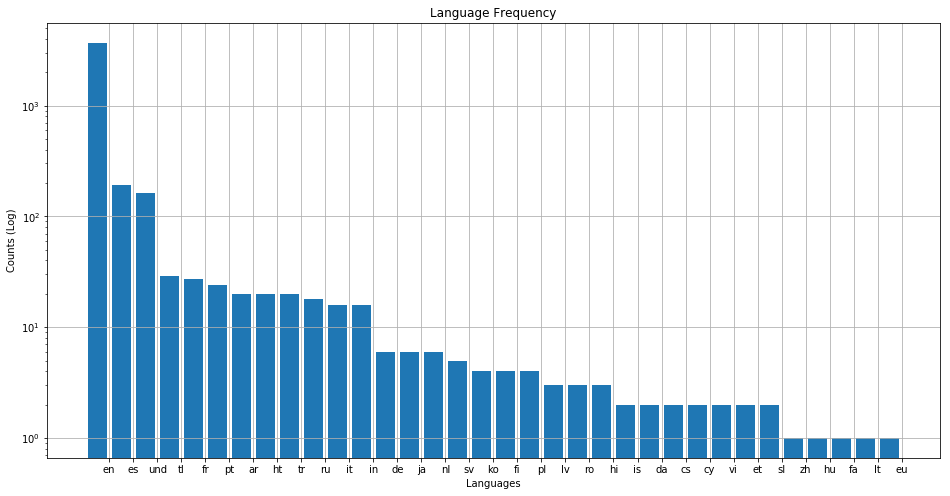

In [18]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.bar(
    np.arange(len(languages)),
    [languageCounter[x] for x in languages],
    log=True)

plt.xticks(np.arange(len(languages)) + 0.5, languages)
plt.xlabel('Languages')
plt.ylabel('Counts (Log)')
plt.title("Language Frequency")
plt.grid(True)

plt.show()

**Quesiton 9**. Now that you have experience in extracting different types of information from twitter data, perform your own EDA. Produce a 1-page report providing some interesting insights about the Sandy twitter data.

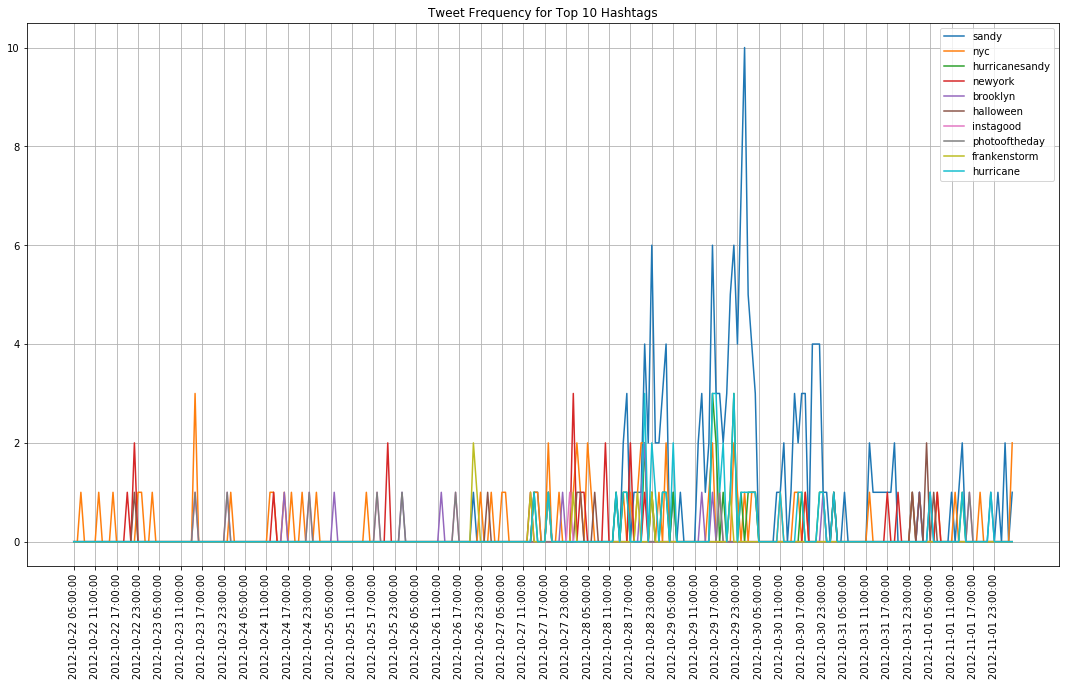

In [22]:
targetKeywords = []

for ht in sortedHashtags[:10]:
    targetKeywords.append(ht)

targetCounts = {x:[] for x in targetKeywords}
totalCount = []

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        
        localTotalCount += 1
        
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            
            for keyword in targetKeywords:
                if ( keyword in hashtagString ):
                    localTargetCounts[keyword] += 1
                    
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])

fig, ax = plt.subplots()
fig.set_size_inches(18.5,10)

plt.title("Tweet Frequency for Top 10 Hashtags")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

#ax.plot(range(len(frequencyMap)), totalCount, label="Total")


for keyword in targetKeywords:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()
fig.savefig("frequency")

Text(0.5,1,'Top 15 Hashtags')

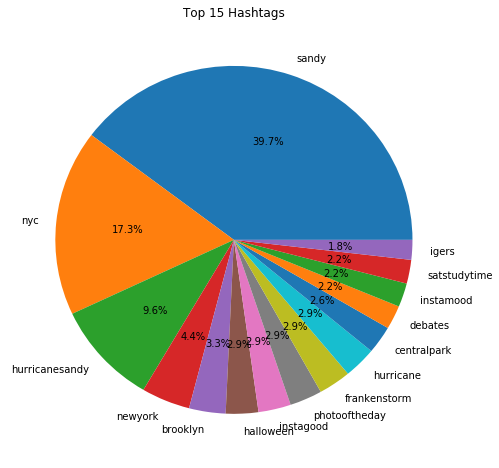

In [72]:
plt.figure(figsize=(8,8))
nhash = sortedHashtags[:15]

for x in nhash:
    ncount = hashtagCounter[x]
plt.pie([hashtagCounter[x] for x in nhash[:15]],
       labels=nhash,autopct='%1.1f%%')

plt.title("Top 15 Hashtags")

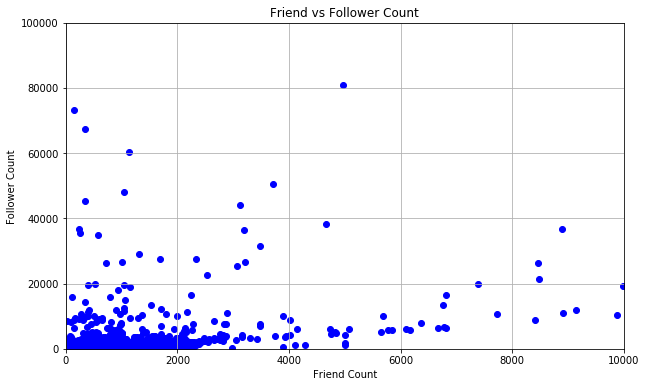

In [23]:
list1=[]
list2=[]
for u in sortedUsersFollow[1:]:
    list1.append(FriendCounter.get(u))
    list2.append(FollowerCounter.get(u))
plt.figure(figsize=(10,6))
plt.scatter(list1,list2,c="blue")
plt.xlabel('Friend Count')
plt.ylabel('Follower Count')
plt.title("Friend vs Follower Count")
plt.xlim(0,10000)
plt.ylim(0,100000)
plt.grid()

    

## Module 2: Classification

In this part of the lab, we will work on a binary classificaiton problem. In particular, we would like to see how easy it is to discriminate between tweets with hashtag #sandy and the rest of them. To do it, we will first create labels: positive tweets will be those with hashtag #sandy and negative those without the hashtag. Then, we we will create a bag-of-words vector out of each tweet, but we will exclude word "#sandy". To produce the bag-of-words representation we will use the `CountVectorizer` functionality 

In [24]:
import pandas as pd
import numpy as np
import codecs, json

"""
Step 1. Create sentences and labels from json file. 
"""
filePath='smallNYC.json'
sents = []
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    sents.append(tweetObj['text'])
    
"""
Step 2.1. Get label. If sent contains '#sandy', label=1; otherwise, label=0
"""
labels = np.array(['#sandy' in sent.split() for sent in sents], dtype='int')
print(pd.Series(labels).value_counts())
"""
Step 2.2. Represent the data into Bag-of-words features, i.e, each sentence is a 
            vector of word counts. 
          a). Only select words with frequency >= 5
          b). Remove label words '#sandy'
"""

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words = ['#sandy'])
features = vectorizer.fit_transform(sents)


print('#sandy' in vectorizer.get_feature_names())
print(features.toarray())
print(vectorizer.get_feature_names())

0    4234
1      61
dtype: int64
False
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['00', '10', '100thingsaboutme', '12', '13', '14', '15', '16', '18', '20', '2012', '21', '24', '26', '28', '2nd', '30', '40', '50', '6th', 'able', 'about', 'actually', 'ads', 'adventure', 'af', 'after', 'afternoon', 'again', 'against', 'ago', 'ain', 'air', 'airport', 'al', 'album', 'alert', 'alive', 'all', 'almost', 'already', 'also', 'always', 'am', 'amazing', 'america', 'american', 'amp', 'an', 'and', 'another', 'any', 'anyone', 'anything', 'anyway', 'apartment', 'apocalypse', 'app', 'apple', 'appreciate', 'aqui', 'are', 'area', 'aren', 'around', 'art', 'as', 'ask', 'asked', 'asleep', 'ass', 'astoria', 'at', 'ave', 'avenue', 'away', 'awesome', 'awkward', 'aww', 'awww', 'babe', 'baby', 'back', 'bacon', 'bad', 'ballroom', 'bar', 'barclays', 'battery', 'be', 'beach', 'beat', 'beautiful', 'because', 'bed', 'been', 'beer', 'before',

**Quesiton 10**. Given the data set of labeled tweets, you have to train a classification model and check the accuracy. Remember to first split the data into training and test. You should explore kNN classification, decision tree classification, Random Forest classification.

In [29]:
#ANSWER 10

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42) 
import time
from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Name of each Predictor
names = [ "Decision Tree", "Random Forest", "K Nearest Neighbors"]

# List of predictors
predictor = [DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               KNeighborsClassifier()]

# Trains each predictor with training data and tests accuracy
for name, clf in zip(names, predictor):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print (name, " accuracy:", score)


Decision Tree  accuracy: 0.9866008462623413
Random Forest  accuracy: 0.9887165021156559
K Nearest Neighbors  accuracy: 0.9880112834978844


**Question 11**. Train the so-called *Logistic regression classifier* and check its accuracy. Compare with the results from *Question 10*. The following lines of code will be useful to do it.

In [30]:
"""
Step 3. Divide data into train and test 
"""
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42) 
import time
from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression()
start_time = time.time()
clf.fit(X_train, y_train)
print('Time for %s fitting: %.3f' % ('LogisticRegression', time.time() - start_time))
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('Test Perf ACC: %.3f, AUC: %.3f' %(accuracy, auc))

Time for LogisticRegression fitting: 0.012
Test Perf ACC: 0.988, AUC: 0.986


### ANSWER 11
- The Logistic Regression  and Random Forest classifiers are the best with 98.8% accurate however the decision tree and K nearest Neighbor are a 0.01% behind which just tells us that it is easy to learn with this data

# Module 3. Extra Credit: Using API to Download Tweets (50 extra points)

To run the following code you will need to install the `tweepy` package.

* Create a twitter account if you do not already have one
* Go to https://apps.twitter.com/ and log in with your twitter credentials.
* Click 'Create New App'
* Fill out the Name, Description, Website fields and agree the terms. Put in any website you want if you don't have one you want to use.
* On the next page, click the 'Keys and Access Tokens' tab along the top, then scroll all the way down until you see the section 'Your Access Token
* Click the button 'Create My Access Token'.
* You will now copy four values below. These values are your 'Consumer Key (API Key)', your 'Consumer Secret (API Secret)', your 'Access token' and your 'Access token secret'. All four should now be visible on the 'Keys and Access Tokens' page. Set the variables corresponding to the API key, API secret, access token, and access secret. You will see code like the below:


In [86]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json, sys
import codecs



ckey = "w3lNYabMRjzSFJGW2H3Vkv9fh"
csecret = "S1lihcz7BgJDRPTDQ7YJ6q4C4E4WDLyXJ6e6g6nF1jxGbJsY1Y"
atoken = "981283468423376896-ms019ntfRHeoKPPnhYgRIN8U9D7RadP"
asecret = "K1F0O9Ms9WaWMVPLP6aiHvtPVwS3Iwgq38KwogeRxabwv"

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

output = codecs.open("twitter_data.json", "wb", encoding="utf-8")
line_num = 0
class CustomStreamListener(StreamListener):
    def on_status(self, status):
        print (status.text)

    def on_data(self, data):
        
        output.write(json.loads(json.dumps(data)))
       
        #output.write(json_data)
        #output.write("\n")

    def on_error(self, status_code):
        print >> sys.stderr, 'Encountered error with status code:', status_code
        return True # Don't kill the stream

    def on_timeout(self):
        print >> sys.stderr, 'Timeout...'
        return True # Don't kill the stream

twitterStream = Stream(auth, CustomStreamListener())
twitterStream.filter(track=['anime'],async=True)

time.sleep(100)
twitterStream.disconnect()

In [88]:
filePath='anime.json'
localTweetList = []
globalTweetCounter = 0
frequencyMap = {}
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    
    # Try to extract the time of the tweet
    currentTime=dateutil.parser.parse(tweetObj['created_at'])
    currentTime = currentTime.replace(second=0)
    currentTime = currentTime.replace(minute=0)

    #print currentTime
    # Increment tweet count
    globalTweetCounter += 1
    
    # If our frequency map already has this time, use it, otherwise add
    if ( currentTime in frequencyMap.keys() ):
        timeMap = frequencyMap[currentTime]
        timeMap["count"] += 1
        timeMap["list"].append(tweetObj)
    else:
        frequencyMap[currentTime] = {"count":1, "list":[tweetObj]}

# Fill in any gaps
times = sorted(frequencyMap.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

#timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
timeIntervalStep = datetime.timedelta(hours=1)
while ( thisTime <= lastTime ):
    if ( thisTime not in frequencyMap.keys() ):
        frequencyMap[thisTime] = {"count":0, "list":[]}

    thisTime = thisTime + timeIntervalStep

print ("Processed Tweet Count:", globalTweetCounter)

Processed Tweet Count: 2495


In [89]:
import matplotlib.pyplot as plt

# Sort the times into an array for future use
sortedTimes = sorted(frequencyMap.keys())

# What time span do these tweets cover?
print ("Time Frame:", sortedTimes[0], sortedTimes[-1])

# Get a count of tweets per minute
postFreqList = [frequencyMap[x]["count"] for x in sortedTimes]


Time Frame: 2018-04-04 18:00:00+00:00 2018-04-04 18:00:00+00:00


In [101]:
# Create maps for holding counts and tweets for each user
globalUserCounter = {}
globalUserMap = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        
        if ( user not in globalUserCounter ):
            globalUserCounter[user] = 1
            globalUserMap[user] = [tweet]
        else:
            globalUserCounter[user] += 1
            globalUserMap[user].append(tweet)

print ("Unique Users:", len(globalUserCounter.keys()))
sortedUsers = sorted(globalUserCounter, key=globalUserCounter.get, reverse=True)
print ("\nTop 20 Most Prolific Users:")
for u in sortedUsers[:20]:
    print (u, globalUserCounter[u], "\n\t", "Random Tweet:", globalUserMap[u][0]["text"], "\n----------")
    
###ANSWER 4
# Create maps for holding friend count for each user
FriendCounter = {}
FollowerCounter ={}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        friendCount= tweet["user"]["friends_count"]
        followerCount= tweet["user"]["followers_count"]
        if ( user not in FriendCounter):
            FriendCounter[user] = friendCount
        if( user not in FollowerCounter):
            FollowerCounter[user]=followerCount
sortedUsersFriend = sorted(FriendCounter, key=FriendCounter.get, reverse=True)
sortedUsersFollow = sorted(FollowerCounter, key=FollowerCounter.get, reverse=True)
print ("\n\nTop 20 Users With Most Friends:")
for u in sortedUsersFriend[:20]:
    print (u,"-", FriendCounter[u], )
print ("\n\nTop 20 Users With Most Followers:")
for u in sortedUsersFollow[:20]:
    print (u,"-", FollowerCounter[u])   
# A map for hashtag counts
hashtagCounter = {}

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            
            if ( hashtagString not in hashtagCounter ):
                hashtagCounter[hashtagString] = 1
            else:
                hashtagCounter[hashtagString] += 1

print ("\nUnique Hashtags:", len(hashtagCounter.keys()))
sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
print ("\nTop Twenty Hashtags:")
for ht in sortedHashtags[:50]:
    print ("\t", "#" + ht, hashtagCounter[ht])

Unique Users: 2228

Top 20 Most Prolific Users:
RandomlyLewd 14 
	 Random Tweet: RT @__anime_com__: #Hentai #Anime #animegirl #anime #animegirl @fu_futa @nunnu_zero @U_S_O @kaza_mitan @tenleid @VR_Hentai @FAKKU @AhegaoOn… 
----------
Legendarypunos5 8 
	 Random Tweet: RT @only__2D: takunomi
#girl #anime #ecchi #ero #kawaii #cute #waifu https://t.co/9vTqEVKt7X 
----------
animemoe_moe 7 
	 Random Tweet: 更新しました。
アニメ萌え : 【重慶の土龍】ゴルゴ13-95【洋上の偽り】
#アニメ #漫画 #同人 #声優 #アニソン #ゲーム #まとめ #漫画 #土龍 #anime #comic #game
https://t.co/j8mT4CmfDg 
----------
BestFitMales 6 
	 Random Tweet: RT @Polls4Gamers2: Favorite black haired character? #anime #DragonBallFighterZ #Naruto #Boruto #DBZKai #DragonBallSuper #Bleach 
----------
SorataStandz 6 
	 Random Tweet: RT @kunitotrejo: RT @game_oxygen999: El #videojuego #DragonBallFighteZ celebra el lanzamiento de Bardock y Broly re… https://t.co/0DuqDFykPr 
----------
7WvXwILvm6dS8xq 6 
	 Random Tweet: RT @ilovepantsuECH: .#ilpHentai #Hentai #Sex #Anime #Manga #lewd  

violetevergarden   5
toriko   5
bobobo   5
attackontitan   6
dragonballsuper   34
legendofkorra   5
boruto   21
bleach   15
onepiece   10
naruto   30
gintama   5
cowboybebop   4
dbzkai   15
dragonballz   10


Text(0.5,1,'Top Anime Shows')

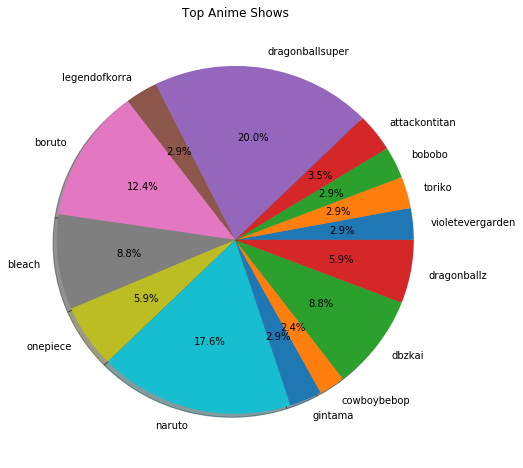

In [112]:
animeShow={"dragonballsuper","naruto","boruto","dbzkai","bleach","onepiece","dragonballz","attackontitan"
          , "gintama","violetevergarden","bobobo","toriko","legendofkorra","cowboybebop"}
animeShowCounter={}
for x in animeShow:
    hold=sortedHashtags.index(x)
    animeShowCounter[x]=hashtagCounter[x];
    print (x , " ",hashtagCounter[x])

plt.figure(figsize=(8,8))
nhash = animeShow

for x in nhash:
    ncount = animeShowCounter[x]
plt.pie([animeShowCounter[x] for x in nhash],
       labels=nhash,autopct='%1.1f%%',shadow=True)

plt.title("Top Anime Shows")

en 1232
ja 631
es 186
fr 103
und 99
pt 95
it 28
tl 27
in 22
tr 19
de 17
eu 7
ht 4
et 4
cs 4
ar 4
ro 3
ca 2
nl 1
fi 1
ru 1
th 1
no 1
pl 1
zh 1
lt 1


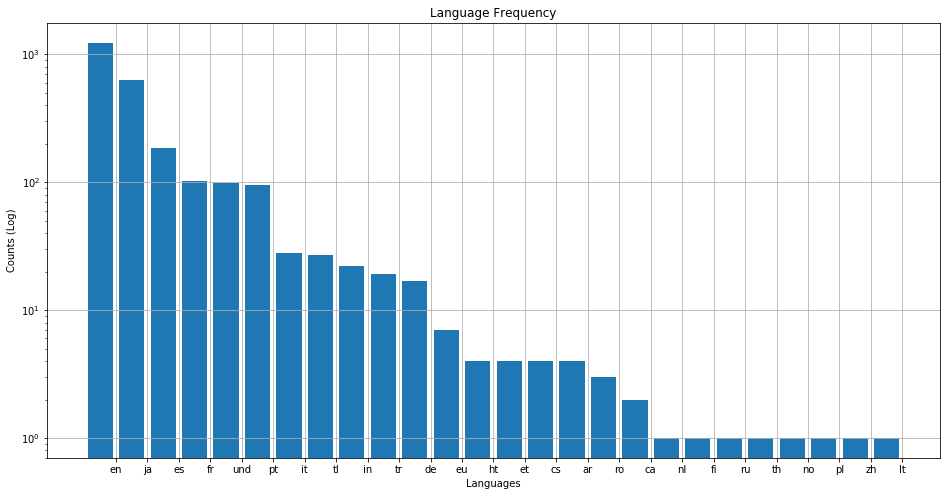

In [92]:
# A map for counting each language
languageCounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        lang = tweet["lang"]
        
        if ( lang not in languageCounter ):
            languageCounter[lang] = 1
        else:
            languageCounter[lang] += 1
            
languages = sorted(languageCounter.keys(), key=languageCounter.get, reverse=True)

for l in languages:
    print (l, languageCounter[l])

plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.bar(
    np.arange(len(languages)),
    [languageCounter[x] for x in languages],
    log=True)

plt.xticks(np.arange(len(languages)) + 0.5, languages)
plt.xlabel('Languages')
plt.ylabel('Counts (Log)')
plt.title("Language Frequency")
plt.grid(True)

plt.show()


Text(0.5,1,'Top 10 Languages Of Tweets About Anime')

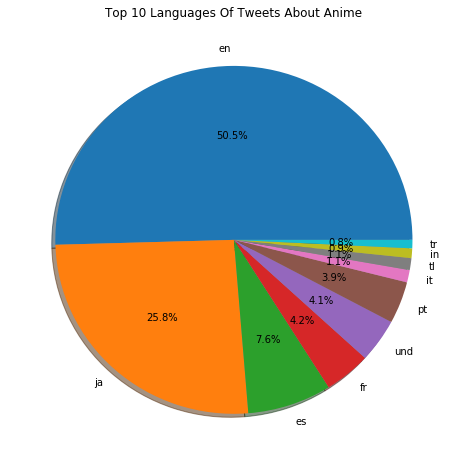

In [96]:
plt.figure(figsize=(8,8))
nhash = languages[:10]

for x in nhash:
    ncount = languageCounter[x]
plt.pie([languageCounter[x] for x in nhash[:10]],
       labels=nhash,autopct='%1.1f%%',shadow=True)

plt.title("Top 10 Languages Of Tweets About Anime")

In [95]:
# Question 6
hashtagCounter={}
hashtagMap = {}
# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            if ( hashtagString not in hashtagCounter ):
                hashtagCounter[hashtagString] = 1
                hashtagMap[hashtagString] = [tweet]
            else:
                hashtagCounter[hashtagString] += 1
                hashtagMap[hashtagString].append(tweet);

sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
for u in sortedHashtags[:2]:
    print ("#", u, ":")
    for tweet in range(0,20):
        print (tweet+1," ",hashtagMap[u][tweet]["text"])
    print ("\n")

# anime :
1   更新しました。
アニメ萌え : 【重慶の土龍】ゴルゴ13-95【洋上の偽り】
#アニメ #漫画 #同人 #声優 #アニソン #ゲーム #まとめ #漫画 #土龍 #anime #comic #game
https://t.co/j8mT4CmfDg
2   RT @DiabloArt: #沙耶の唄
#沙耶
I got to do this Saya from Saya no uta tonight. 
#DiabloArt #yokohamatattoo #anime #animetattoo #saya #sayanouta #…
3   Fav!💙 AnimeGirls!❄ RT!😍
💙❄❤❄💚❄💛❄💜❄💙❄
#kawaii #cute #Elf #manga #Girls2D #Anime  #AnimeGirl #waifu #RTandFAV #2D… https://t.co/9BZhqimJCd
4   #nowplaying on #Anime Fandom #Radio  Thinking Dogs / そんな君、こんな僕 -NARUTO ED ver.-  https://t.co/fiYBFDYcyB
5   takanashi_kei_(hitsujikan)
#girl #anime #ecchi #ero #kawaii #cute #waifu https://t.co/C27Io1XIyU
6   【モンスト】過去最高の産廃じゃん…突如発表されたモンストクローバー獣神化性能にユーザーから不満の声が殺到中ｗｗｗｗ #モンスト #anime 
https://t.co/DSEaJX5pIx
7   RT @hanzaruku: My Review of Grave of the fireflies by Studio Ghibli http://t.co/Klygyzm3Kr #bubblews #anime
8   RT @ImagenTVMex: #anime ¿Ya estás preparado? ¡Llega este fin de semana el maratón de #MazingerZ! Sábado y domingo a partir de las 8 am por…
9   RT @an

Pacific Time (US & Canada)   372
Eastern Time (US & Canada)   115
Central Time (US & Canada)   103
Tokyo   40
Brasilia   35
Paris   28
Madrid   28
Amsterdam   27
Athens   23
London   22
Atlantic Time (Canada)   20
Mexico City   18
Quito   17
Buenos Aires   17
Arizona   16
Jakarta   12
Irkutsk   12
Santiago   11
Beijing   11
Mid-Atlantic   9


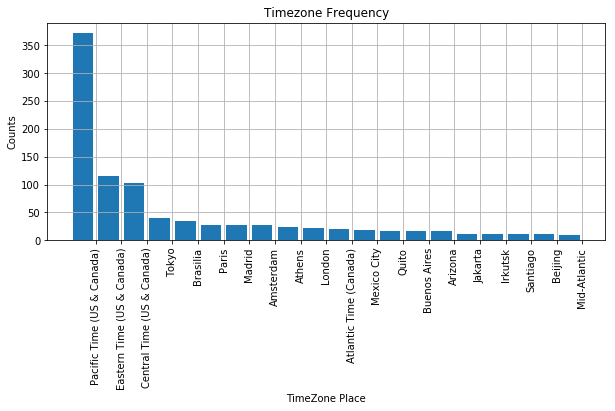

In [127]:
# Create maps for holding counts and tweets for each user
PlaceCounter = {}
Place = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        if(tweet["user"]["time_zone"]!=None):
            place=tweet["user"]["time_zone"];
            if (place not in Place ):
                PlaceCounter[place] = 1
                Place[place] = place
            else:
                PlaceCounter[place] += 1
sortedPlace = sorted(PlaceCounter, key=PlaceCounter.get, reverse=True)
for place in sortedPlace[:20]:
    print (place , " ", PlaceCounter[place])
plt.figure(figsize=(10,4))
    
# the histogram of the data
plt.bar(
    np.arange(len(sortedPlace[:20])),
    [PlaceCounter[x] for x in sortedPlace[:20]],)

plt.xticks(np.arange(len(sortedPlace[:20])) + 0.5, sortedPlace[:20],rotation=90)
plt.xlabel('TimeZone Place')
plt.ylabel('Counts')
plt.title("Timezone Frequency")
plt.grid(True)

plt.show()

You can stop downloading by terminating the process (the stop button in Jupiter menu)

Now you can also filter Tweets by locations by setting the parameters in filter.
By setting the filter(locations = [-75.280291,39.867005,-74.955831,40.137959]), you will
get all tweets from Philadelphia. To get bounding box for other areas, the klokantech's tool can
be used. 
To learn more about Twitter Stream API parameters, please go to: 
    https://dev.twitter.com/streaming/overview/request-parameters 
    
** Extra point Question**. Pick you favorite geographical region, keyword, or a hashtag and download at least 1,000 tweets. Perform any kind of exploratory or predictive data analysis that you find interesting and produce a 2-page report summarizing what you did and why and explaining what kind of results nd insights you obtained.

